In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [2]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [3]:
import pandas as pd

In [4]:
df_collar = pd.read_csv("../data/locations.csv")

../data/2319.csv, base freq:75 Hz


Text(0, 0.5, 'Voltage (mV/Am2)')

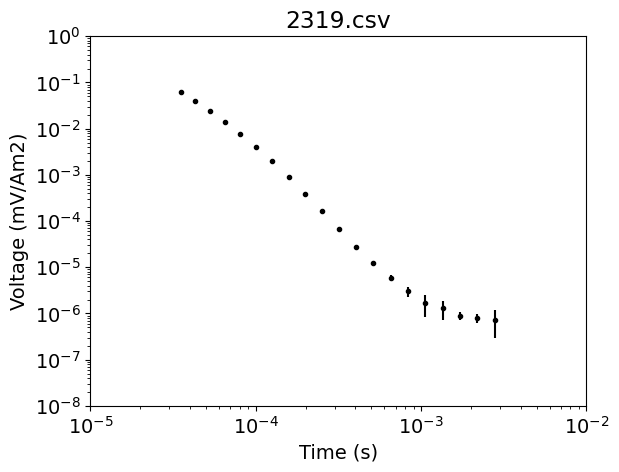

In [25]:
kk = 18
ii = 3
#colors = ['k', 'b']

df = pd.read_csv(folder_path+csv_files[kk])
df_group = df.groupby('f (Hz)')
base_freqs  = list(df_group.groups.keys())

base_freq = base_freqs[ii]
print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
df_tmp = df_group.get_group(base_freq)
i_time_start=0
voltage = df_tmp['V (mV/Am2)'].values[i_time_start:]
noise = df_tmp['N (mV/Am2)'].values[i_time_start:]
times = df_tmp['Time (s)'].values[i_time_start:]
plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
plt.xscale('log')
plt.yscale('log')
# plt.loglog(times, noise, '.')
plt.ylim(1e-8, 1)
plt.xlim(1e-5, 1e-2)
plt.title(csv_files[kk])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")

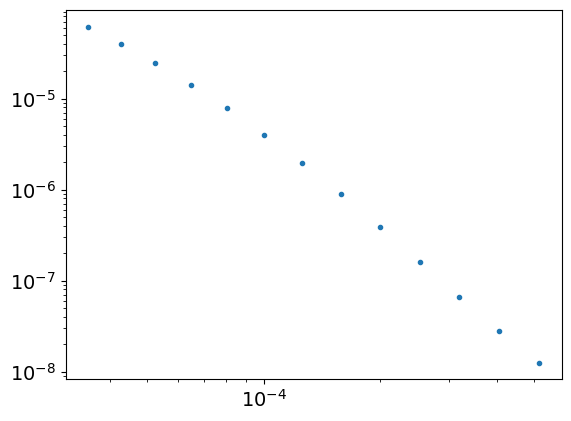

In [39]:
i_time_start=0
i_time_end = 13
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times[i_time_start:i_time_end], orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)
# 5% of the absolute value
uncertainties = (0.05 * np.abs(voltage*1e-3) * np.ones(np.shape(voltage*1e-3)))[i_time_start:i_time_end]
dobs = -voltage[i_time_start:i_time_end]*1e-3
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
plt.loglog(times[i_time_start:i_time_end], -data_object.dobs, '.')
plt.loglog(times[i_time_start:i_time_end], +data_object.dobs, '.')

In [40]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [41]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [42]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [43]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [44]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [45]:
source_area = 10000

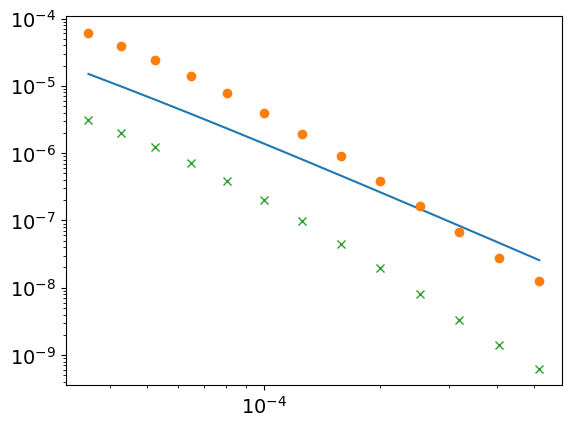

In [46]:
m0 = np.log(1./100 * np.ones(n_layers))
reference_conductivity=m0.copy()
dpred = simulation_L2.dpred(m0)
plt.loglog(times[i_time_start:i_time_end], -dpred)
plt.loglog(times[i_time_start:i_time_end], -dobs, 'o')
plt.loglog(times[i_time_start:i_time_end], uncertainties, 'x')
#print(n_layers)
#print(n_layers_model)

In [47]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [48]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 25 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     25       -376.31         -0.00      1.80     44.80    1.15




In [49]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    reference_model_in_smooth=False,
    alpha_s=1e-10,
    alpha_x=1,
)
opt_L2 = optimization.InexactGaussNewton(
    maxIter=15, maxIterLS=10, maxIterCG=50, tolCG=1e-3
)
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_dict = directives.SaveOutputDictEveryIteration()
directives_list_L2 = [starting_beta, beta_schedule, target_misfit, save_dict]
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   0  3.51e+02  2.17e+03  1.84e-31  2.17e+03    7.23e+02      0              
   1  3.51e+02  1.60e+03  1.37e-02  1.61e+03    1.92e+03      2              
   2  3.51e+02  7.75e+02  3.25e-02  7.86e+02    1.82e+03      1              
   3  1.76e+02  1.80e+02  7.20e-02  1.93e+02    1.20e+03      0   Skip BFGS  
   4  1.76e+02  6.48e+01  1.25e-01  8.69e+01    8.00e+02      0   Skip BFGS  
   5  1.76e+02  1.94e+01  1.26e-01  4.15e+01    1.07e+02      0   Skip BFGS  
   6  8.79e+01  1.91e+01  1.23e-01  2.98e+01    8.51e+00      0   Skip BFGS  
   7  8.79e+01  1.74e+01  1.34e-01  2.92e+01    4.33e+01      2              
   8  8.79e+01  1.63e+01  1.43e-01  2.88e+01    5.37e+01      2   Skip BFGS  
   9  4.39e+01  1.50e+01  1.57e-01  2.18e+01    7.30e+01      1   Skip BFGS  
  10  4.39e+01  1.40e+01  1.74e-01  2.17e+01    1.24e+02      2   Skip BFGS  
  11  4.39e+01  1.32e+01  1.87e-01  2.14e+01    1.35e+02      2   Skip BFGS  
------------------------- STOP! -------------------------
1 : |f

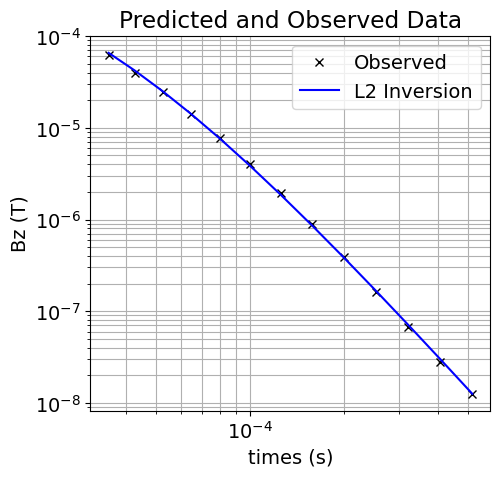

In [52]:
iterations = list(save_dict.outDict.keys())
iteration = 11
m_rec = save_dict.outDict[iteration]['m']
sigma_rec = log_conductivity_map * m_rec
dpred_rec = save_dict.outDict[iteration]['dpred']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times[i_time_start:i_time_end], np.abs(dobs), "kx")
ax1.loglog(times[i_time_start:i_time_end], np.abs(dpred_rec), "b-")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

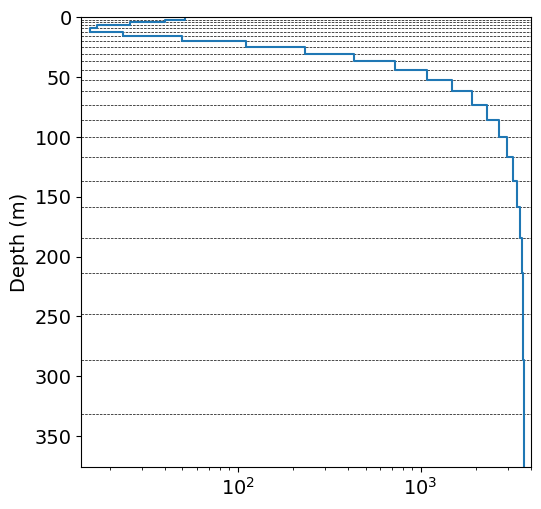

In [53]:
ax = plot_1d_layer_model(layer_thicknesses, 1./sigma_rec, show_layers=True)
# ax.set_xlim(5, 5e3)
# ax.grid(True, alpha=0.5)